In [1]:
from google.colab import drive
import numpy as np
import seaborn as sns
import zipfile
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Add, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_file_path = '/content/drive/MyDrive/Teeth DataSet.zip'
extract_dir = '/content/Teeth DataSet/'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Files extracted to:", extract_dir)

Files extracted to: /content/Teeth DataSet/


In [3]:
for root, dirs, files in os.walk(extract_dir):
    for name in files:
        print(os.path.join(root, name))

Streaming output truncated to the last 5000 lines.
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1207_0_2652.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1211_0_661.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1262_0_9721.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1248_0_9818.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1222_0_7221.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1228_0_1449.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1240_0_9340.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1245_0_1413.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1236_0_9894.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1200_0_8241.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1256_0_7680.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1251_0_2191.jpg
/content/Teeth DataSet/Teeth_Dataset/Validation/OT/ot_1229_0_5069.jpg
/content/Teeth DataSet/Teeth_Dataset/Val

#1. Preprocessing

In [4]:
train_dir = '/content/Teeth DataSet/Teeth_Dataset/Training'
validation_dir = '/content/Teeth DataSet/Teeth_Dataset/Validation'
test_dir = '/content/Teeth DataSet/Teeth_Dataset/Testing'
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

#2. Data Augmentation and Normalization

In [5]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

# for training
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#for validation (no augmentation, only rescaling)
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#for testing (no augmentation, only rescaling)
test_data_gen = validation_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1508 images belonging to 10 classes.


#2. Visualization

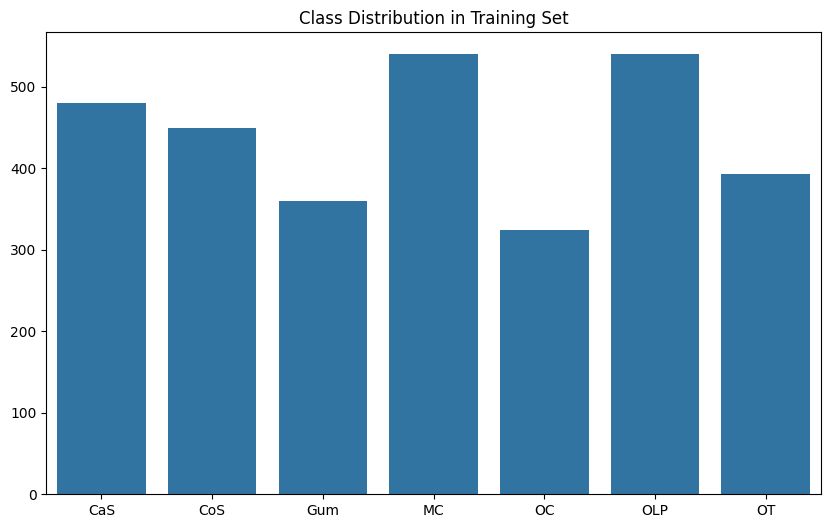

In [6]:
labels = list(train_data_gen.class_indices.keys())
class_counts = [np.sum(train_data_gen.classes == i) for i in range(len(labels))]
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=class_counts)
plt.title('Class Distribution in Training Set')
plt.show()

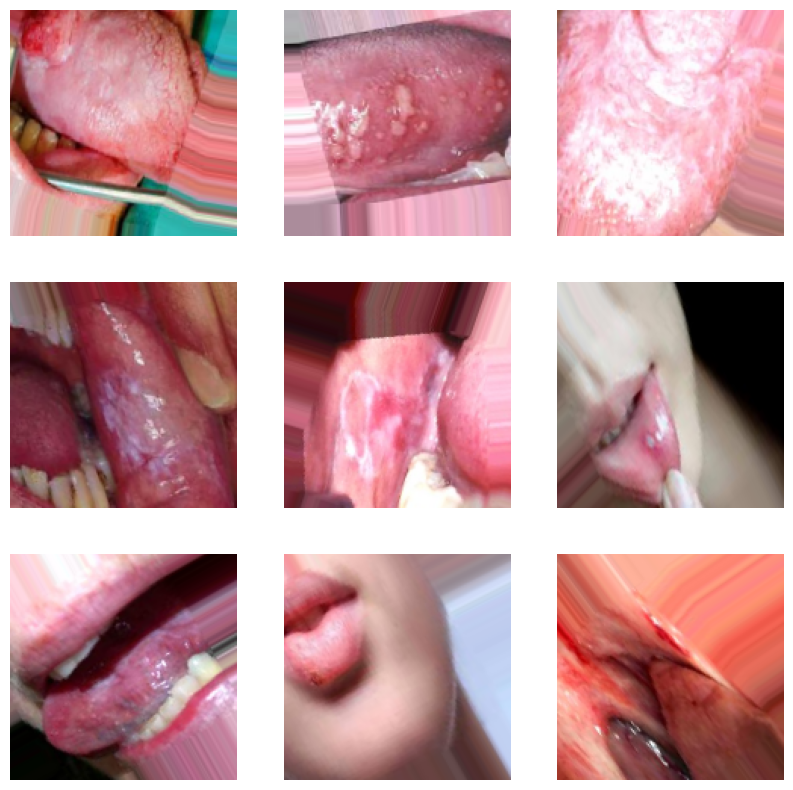

In [7]:
def plot_augmented_images(data_gen):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img, label = next(data_gen)
        plt.imshow(img[0])
        plt.axis('off')
    plt.show()

# Plot a batch of augmented images
plot_augmented_images(train_data_gen)

#3. Model Architecture and Training

In [8]:
def build_model_efficientnet():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x_dense = Dense(512, activation='relu')(x)

    # skip connection to match shapes
    skip = base_model.get_layer('block6a_expand_activation').output
    skip = Conv2D(512, (1, 1), activation='relu')(skip)
    skip = GlobalAveragePooling2D()(skip)
    x_dense = Dense(512)(x_dense)
    x = Add()([x_dense, skip])
    predictions = Dense(7, activation='softmax')(x)  # Output layer with 7 units for 7 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Build and compile the model
model = build_model_efficientnet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,316,266 (20.28 MB)

 Trainable params: 5,274,243 (20.12 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
EPOCHS = 100
# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 147s 718ms/step - accuracy: 0.5248 - loss: 1.3844 - val_accuracy: 0.1455 - val_loss: 8.2244
Epoch 2/100
 1/96 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8750 - loss: 0.5517

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8750 - loss: 0.5517 - val_accuracy: 0.0000e+00 - val_loss: 7.5392
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 229ms/step - accuracy: 0.8575 - loss: 0.4274 - val_accuracy: 0.1455 - val_loss: 6.4644
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.3032 - val_accuracy: 0.0000e+00 - val_loss: 5.8651
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - accuracy: 0.8830 - loss: 0.3795 - val_accuracy: 0.1445 - val_loss: 3.4716
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.9062 - loss: 0.2114 - val_accuracy: 0.2500 - val_loss: 3.3848
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.9134 - loss: 0.2754 - val_accuracy: 0.1445 - val_loss: 2.7418
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1635 - val_accuracy: 0.2500 - val_loss: 2.2453
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.9322 - loss: 0.2457 - val_accuracy:

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(val_data_gen)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9720 - loss: 0.0717
Validation Accuracy: 97.86%
